In [40]:
# Kode untuk melatih mesin belajar data pola serangan web 
# seperti SQLi, dan XSS
# kode diadaptasi dari https://www.kaggle.com/code/tuantc3751/web-acesslog-detection-attack/notebook
# by Henry Saptono

In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics

from scipy.sparse import issparse
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [39]:
# Baca data pola serangan web yang telah di labeli (SQLi, XSS, Normal)
# file data pola bisa diunduh disini https://huggingface.co/datasets/shengqin/web-attacks/blob/main/all.csv
data = pd.read_csv("/home/boy/Testing/AI/cyber/dataset/web_attacks/web_attacks_all.csv")
data.head()

,Payload,Label,text_label,ID
0,<xss onafterscriptexecute=alert(1)><script>1</...,1,XSS,1
1,<style>@keyframes x{from {left:0;}to {left: 10...,1,XSS,2
2,"<style>@keyframes x{}</style><xss style=""anima...",1,XSS,3
3,<style>@keyframes slidein {}</style><xss style...,1,XSS,4
4,"<style>@keyframes x{}</style><xss style=""anima...",1,XSS,5


In [4]:
data.tail()

,Payload,Label,text_label,ID
53905,Select a painting style for expression.,0,normal,53906
53906,Select the right playlist for the mood.,0,normal,53907
53907,Select a tea flavor to relax.,0,normal,53908
53908,Select a style for the haircut.,0,normal,53909
53909,Select the appropriate app for the task.,0,normal,53910


In [22]:
# set train_data dengan fitur Payload
# dan label_data dengan text_label
train_data = data["Payload"].values
label_data = data["text_label"].values

#bagi data untuk berlatih dan untuk test
X_train, X_test, y_train, y_test = train_test_split(train_data, label_data, test_size=0.2, random_state=42)

In [23]:
print(train_data)

['<xss onafterscriptexecute=alert(1)><script>1</script>'
 '<style>@keyframes x{from {left:0;}to {left: 1000px;}}:target {animation:10s ease-in-out 0s 1 x;}</style><xss id=x style="position:absolute;" onanimationcancel="print()"></xss>'
 '<style>@keyframes x{}</style><xss style="animation-name:x" onanimationend="alert(1)"></xss>'
 ... 'Select a tea flavor to relax.' 'Select a style for the haircut.'
 'Select the appropriate app for the task.']


In [24]:
print(label_data)

['XSS' 'XSS' 'XSS' ... 'normal' 'normal' 'normal']


In [8]:
print(X_train)

[' modo=registro&login=sabin&password=m71ale8O&nombre=Devoto&apellidos=Aurich+Mach&email=harra-kilian@zonamodelos.ag&dni=02265933L&direccion=C/+Puente+Ulla,+182+6B&ciudad=Villanueva+de+la+Jara&cp=50299&provincia=Madrid&ntc=6764514910322971&B1=Registrar'
 "-1603'   )    )    or 5903  =    (  'qqpjq'||  (  select case 5903 when 5903 then 1 else 0 end from rdb$database  )  ||'qzvzq'  )   and    (    (   'abmo'  =  'abmo"
 '<img\\x13src=x onerror="javascript:alert(1)">' ...
 ' modo=registro&login=osburn&password=48AsTa5O&nombre=Edilio&apellidos=Credid�o+Poma&email=ahern.plott@zonamodelos.fr&dni=36839675T&direccion=Patio+Pico+De+Aneto,+122+13-C&ciudad=Cuevas+del+Almanzora&cp=10666&provincia=Zamora&ntc=1933711327714835&B1=Registrar'
 '<DIV STYLE="background-image: url(javascript:alert(\'XSS\'))">'
 '<style>:target {color: red;}</style><figure id=x style="transition:color 10s" ontransitioncancel=alert(1)></figure>']


In [25]:
print(y_train)

['normal' 'SQLi' 'XSS' ... 'normal' 'XSS' 'XSS']


In [10]:
print(X_test)

['<video draggable="true" ondragend="alert(1)">test</video>'
 ' union all select @@version--'
 'modo=registro&login=lena&password=ATE7t3r&nombre=Solana&apellidos=Ugartechea+Oviol&email=fortes@corjet.au&dni=84082482W&direccion=C/+Cardenal+Cisneros+70,+12?D&ciudad=Peligros&cp=22416&provincia=Zaragoza&ntc=8590730598040371&B1=Registrar'
 ... 'Krish,Muthukumarasamy,6155,Air Defense Artillery (ADA)'
 ' modo=registro&login=missagh&password=f�sforo&nombre=Danilo&apellidos=Lizancos&email=pambieri2@ofertachina.uz&dni=71823012S&direccion=Antonio+Diaz+Ca�abate,+4+&ciudad=Sada&cp=26315&provincia=Madrid&ntc=1872652721088386&B1=Registrar'
 '<a href="\\x15javascript:javascript:alert(1)" id="fuzzelement1">test</a>']


In [26]:
print(y_test)

['XSS' 'SQLi' 'normal' ... 'normal' 'normal' 'XSS']


In [12]:
print(X_train.shape)

(43128,)


In [14]:
print(y_train.shape)

(43128,)


In [15]:
print(X_test.shape)

(10782,)


In [16]:
print(y_test.shape)

(10782,)


In [28]:
# Mengubah teks menjadi vektor fitur yang dapat digunakan sebagai input ke estimator.
vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(3, 3), max_features=8000)
# Transform the training data into a TF-IDF matrix
tfidf_train = vectorizer.fit_transform(X_train)  # (19882, 8000) sparse matrix
tfidf_test = vectorizer.transform(X_test)  # (4971, 8000) sparse matrix

# Convert sparse matrices to dense
X_train_dense = tfidf_train.toarray()  # (19882, 8000)
X_test_dense = tfidf_test.toarray()  # (4971, 8000)
X_train_dense = X_train_dense.reshape((X_train_dense.shape[0], X_train_dense.shape[1], 1))
X_test_dense = X_test_dense.reshape((X_test_dense.shape[0], X_test_dense.shape[1], 1))

In [29]:
# mengubah variabel kategoris ke dalam bentuk numerik.
label_encode = LabelEncoder()
y_test_encode = label_encode.fit_transform(y_test)
y_train_encode = label_encode.transform(y_train)
# One-hot encoding for multi-class classification
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_encode = one_hot_encoder.fit_transform(y_train_encode.reshape(-1, 1))
y_test_encode = one_hot_encoder.transform(y_test_encode.reshape(-1, 1))

# Buat model
random_forest_model = RandomForestClassifier(random_state=1000)
print('Computing....')
# Fit the model
random_forest_model.fit(tfidf_train,y_train_encode)
print('Done!')

Computing....
Done!


In [30]:
# Predict test
RT_predictions= random_forest_model.predict(tfidf_test)
print('MAE', mean_absolute_error(y_test_encode, RT_predictions))
print("Accuracy", accuracy_score(y_test_encode, RT_predictions))
print("Precision", precision_score(y_test_encode, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("Recall", recall_score(y_test_encode, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("F1", f1_score(y_test_encode, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
print("ROC AUC", roc_auc_score(y_test_encode, RT_predictions, average='weighted', labels=np.unique(RT_predictions)))
error_rt = (RT_predictions != y_test_encode).mean()
print("Test error: {:.1%}".format(error_rt))

MAE 0.0028133308600754342
Accuracy 0.9948989055833797
Precision 0.9949466051617541
Recall 0.9984978218416705
F1 0.9967089241826161
ROC AUC 0.9967858386544756
Test error: 0.3%


Confusion Matrix:
[[2993    0    1]
 [   7 3655    1]
 [  45    0 4080]]


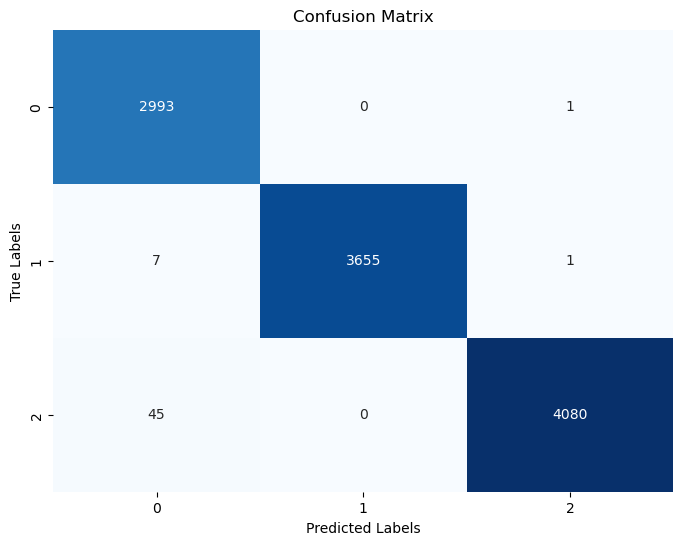

In [31]:
import seaborn as sns
# Make predictions on the test data
y_pred_prob = random_forest_model.predict(tfidf_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_encode, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
# Vẽ heatmap cho confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# mengubah label input menjadi label biner
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)
y_train_binary = label_binarizer.fit_transform(y_train)

In [33]:
print(y_test)
print(y_train)
print(y_test_binary[0])
print(y_test[0])

['XSS' 'SQLi' 'normal' ... 'normal' 'normal' 'XSS']
['normal' 'SQLi' 'XSS' ... 'normal' 'XSS' 'XSS']
[0 1 0]
XSS


In [34]:
print("Class labels:", label_binarizer.classes_)

Class labels: ['SQLi' 'XSS' 'normal']


In [35]:
# Simpan model dan vectorizer ke file pickle
import pickle

pickle.dump(random_forest_model, open("/home/boy/Testing/AI/cyber/dataset/web_attacks/web_detect2.model", 'wb'))
pickle.dump(vectorizer, open("/home/boy/Testing/AI/cyber/dataset/web_attacks/web_detect2.vectorizer", 'wb'))

In [36]:
# Menguji  memuat ulang model dari file
model_load= pickle.load(open('/home/boy/Testing/AI/cyber/dataset/web_attacks/web_detect.model','rb'))

In [37]:
# Coba memprediksi
cek_x = np.array(["<script>alert()</script>","q=' union select 1,2 --'"])
tfidf_cek_x = vectorizer.transform(cek_x)
X_ = tfidf_cek_x.toarray() 

y_ = model_load.predict(X_)
print(y_)
print(label_binarizer.classes_)

[[0. 1. 0.]
 [1. 0. 0.]]
['SQLi' 'XSS' 'normal']


In [38]:
for i in y_:
    print(label_binarizer.classes_[np.where(i==1)[0:]])

['XSS']
['SQLi']
